In [1]:
### Imports ###

include("../src/QComp.jl")
using .QComp

using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random

In [223]:
### Example: random vs uniform states ###

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = [rand_state(n) for i=1:n_samples*2]
states2 = [uniform_state(n) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

In [217]:
### Example: high- vs low- entanglement states ###

function classify_state(n, label; threshold=0.6, max_iter=1000)
    state = rand_state(n)
    iter = 0
    if label == 1
        while von_neumann_entropy(state, 1) < threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    else
        while von_neumann_entropy(state, 1) > threshold && iter < max_iter
            state = rand_state(n)
            iter += 1
        end
    end
    if iter == max_iter
        error("Could not generate state")
    end
    return state
end

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 10
states1 = [classify_state(n, 1) for i=1:n_samples*2]
states2 = [classify_state(n, -1) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

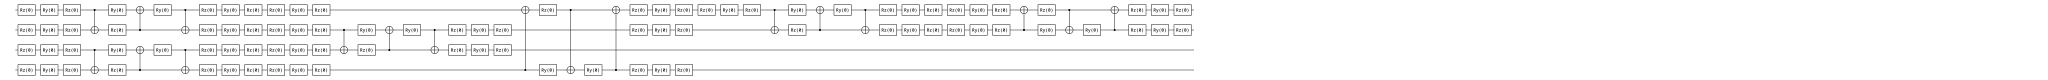

In [224]:
### Model parameters ###

iters = 300
# Using ADAM optimiser in source code.
# See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.
lr = 0.05  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
sig = true
ansatz = conv_SU4 # conv_Ry, conv_Ry2, conv_SU4

circ = build_QCNN(n, ansatz=ansatz)

p = GenericParams(n=n, circ=circ)
# p = InvariantParams(n=n, circ=circ, ansatz=ansatz)
initialize_params(p);

YaoPlots.plot(circ)

In [225]:
### Run ###
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(d1, d2, p, iters, sig, lr; output=false)

Initial: loss = 0.6623027580653256,tr_acc = 0.775, te_acc = 0.725
Final: loss = 0.0011430604243280861,tr_acc = 1.0, te_acc = 0.7


([2.130056897927139, 2.174293729361375, 5.418485768317875, 5.19290686164897, 2.5006289538547737, 1.7776855233756859, 4.298017693450654, 1.8390370978754882, 4.662118690003673, 2.8122613348541363  …  3.349486696843537, 4.741697401527454, 4.246722368226072, 2.2315814935081697, 4.590253098512004, 0.030558640127701035, 3.5087731275257674, 3.7772815210601016, 0.3517944502657718, 2.485099665262851], [0.6623027580653256, 0.40789100224862296, 0.2837552947461998, 0.22823973175740286, 0.1283401968880448, 0.09826207382842855, 0.09451030020250147, 0.06898579860723707, 0.043726637789197435, 0.03294452259564976  …  0.0011589248955088248, 0.0011571354847953778, 0.0011553528652751238, 0.0011535769866554242, 0.0011518077983657578, 0.0011500452495723159, 0.0011482892891931749, 0.0011465398659137973, 0.001144796928202773, 0.0011430604243280861], [0.775, 0.85, 0.925, 0.875, 0.95, 0.975, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.725, 0.775, 0.75, 0.775, 0.825, 0.85, 0.85, 

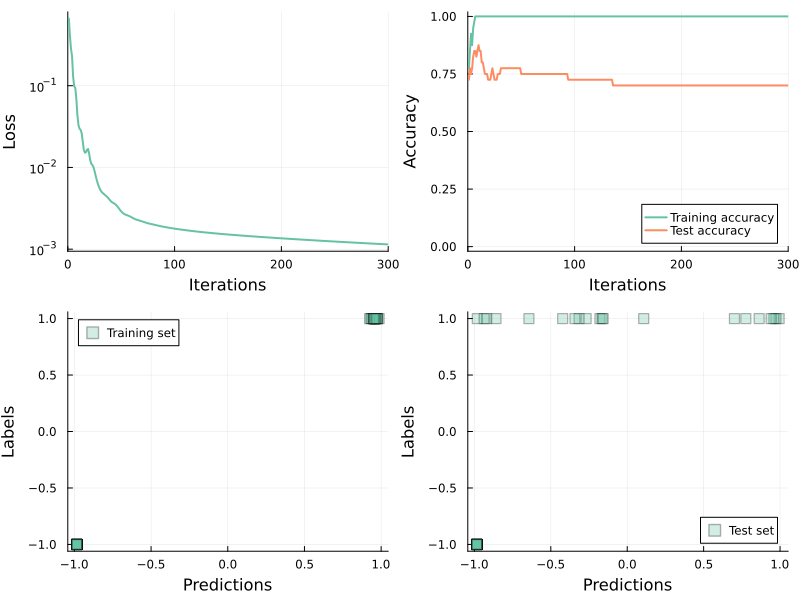

In [226]:
### Plots ###

# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
Plots.plot!(loss_track, yaxis=:log, label=false)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy")
Plots.plot!(te_track, label="Test accuracy")

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set")

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set")

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))